In [ ]:
# Veja mais no Medium

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [2]:
# o effect size é a mudança desejada. 
# nesse caso, está dizendo que tem uma taxa de treze porcento e quer chegar até 15 porcento de sucesso

effect_size = sms.proportion_effectsize(0.13, 0.15)     

# Aqui está dizendo qual o minímo de amostras que é necessário. 
# O power = 0.8 é uma conveção, o alpha como 0,05 significa que qualquer ateração menor que isso não vale a pena considerar


required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  

# Arredonda pra cima
required_n = ceil(required_n)                                                  

print(required_n)

4720


In [3]:
# Subi os arquivos e mostrei o topo

df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
df.info()

In [4]:
# cruzando as tabelas e verificando onde os dados se cruzam, parecido com pivotar

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [5]:
#verificando se usuários aparecem mais do que uma vez

session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'Há {multi_users} usuários que aparecem múltiplas vezes no dataset')

Há 3894 usuários que aparecem múltiplas vezes no dataset


In [6]:
# Apagou os usuários que se repetem


users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'O dataset foi atualizado e agora tem {df.shape[0]} entradas')

O dataset foi atualizado e agora tem 286690 entradas


In [7]:
# Criando o grupo controle e o experimental de maneira randômica

control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=23)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=23)

# juntando as amostras
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [13]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,834087,2017-01-18 10:09:17.394053,control,old_page,0
1,718217,2017-01-20 22:04:31.689015,control,old_page,0
2,639050,2017-01-12 13:36:55.215330,control,old_page,0
3,640643,2017-01-03 06:38:40.454354,control,old_page,0
4,818517,2017-01-05 16:51:36.579900,control,old_page,0
...,...,...,...,...,...
9435,889139,2017-01-10 15:14:01.142235,treatment,new_page,0
9436,876996,2017-01-09 03:06:31.312259,treatment,new_page,0
9437,646019,2017-01-16 09:18:23.629091,treatment,new_page,0
9438,851704,2017-01-13 21:10:14.611902,treatment,new_page,0


In [ ]:
ab_test.info()

In [8]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [9]:
# Vendo a taxa de conversão por grupo

conversion_rates = ab_test.groupby('group')['converted']

# Criando uma função para o desvio padrão
std_p = lambda x: np.std(x, ddof=0)              

#  Criando outra função para calcular o erro do desvio 
se_p = lambda x: stats.sem(x, ddof=0)            

# O agg aplica as funções na lista no dataframe 
conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.121,0.326,0.005
treatment,0.128,0.334,0.005


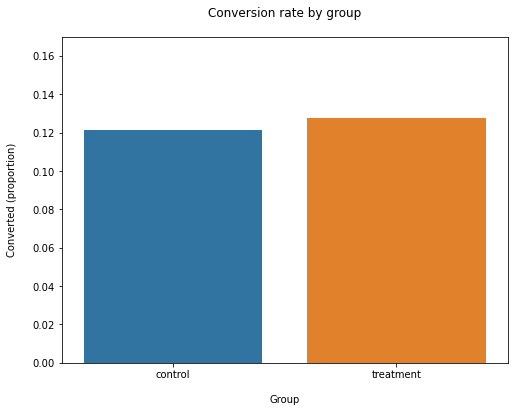

In [10]:
# Plotando os gráficos  e mostrando que a taxa não mudou muito

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [14]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [15]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [16]:
n_con = control_results.count()
n_treat = treatment_results.count()

# successes: todos os convertidos em uma lista
successes = [control_results.sum(), treatment_results.sum()]

# Todos os casos em uma lista
nobs = [n_con, n_treat]

# Separando os sucessos dos casos totais
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.97
p-value: 0.334
ci 95% for control group: [0.112, 0.130]
ci 95% for treatment group: [0.118, 0.137]


In [ ]:
successes = [control_results.sum(), treatment_results.sum()]